In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
from rmab.utils import get_results_matching_parameters, filter_pareto_optimal
from rmab.plots import plot_line_plot_parameter
import seaborn as sns
import itertools 

In [3]:
plt.style.use('ggplot')

In [4]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

In [5]:
method_to_nice = {
    'random_rewards': 'Random',
    'optimal_rewards': 'Whittle (Oracle)',
    'wiql_rewards': 'WIQL', 
    'ucw_perfect_rewards': 'Approx. Whittle + Known Distance (Oracle)',
    'extreme_rewards': 'Extreme', 
    'ucb_rewards': 'UCB', 
    'ucb_fixed_rewards': 'UCB w/o Normal',
    'fixed_rewards': 'UCB w/o Normal',
    'norm_rewards': 'UCB + Normal.',
    'predicted_optimal_match_rewards': 'UCB Match',
    'qp_fixed_rewards': 'QP',
    'value_fixed_rewards': 'Value',
    'optimal_match_rewards': 'Whittle Match (Oracle)',
    'whittle_approximate_rewards': 'Whittle Approx. Match (Oracle)',
    'zero_step_rewards': 'Myopic Zero-Step', 
    'one_step_rewards': 'Myopic One-Step',
    'infinite_step_rewards': 'Myopic Infinite-Step',
    'combined_rewards': 'Combined',
    'ucw_match_rewards': 'UCW + Whittle Match'
}

match_to_nice = {
    'random_match': 'Random',
    'optimal_match': 'Optimal',
    'wiql_match': 'WIQL', 
    'extreme_match': 'Extreme', 
    'ucb_match': 'UCB', 
    'fixed_match': 'Fixed',
    'qp_match': 'QP',
    'value_match': 'Value', 
}

## Baseline Bandit

In [ ]:
seeds = [42,43,44]
data = get_results_matching_parameters("baseline","results",{'n_arms': 8, 'budget': 3})
data = sorted(data,key=lambda k: k['parameters']['seed'])
full_data = {}
for i in data[0]['mean_reward']:
    mean_val = np.round(np.mean([j['mean_reward'][i] for j in data]),2)
    std_val = np.round(np.std([j['mean_reward'][i] for j in data]),2)
    full_data[i] = (mean_val,std_val)

for m in method_to_nice:
    if m in full_data:
        full_data[method_to_nice[m]] = full_data.pop(m)

matching_performance = {}
for i in data[0]['match_rate']:
    mean_val = np.mean([j['match_rate'][i] for j in data])
    std_val = np.std([j['match_rate'][i] for j in data])
    matching_performance[i] = (mean_val,std_val)

for m in match_to_nice:
    if m in matching_performance:
        matching_performance[match_to_nice[m]] = matching_performance.pop(m)


In [ ]:
latex_table = f"""
\\begin{{table}}
    \\centering
    \\begin{{tabular}}{{@{{}}lccc@{{}}}}
        \\toprule
        Algorithm & \\multicolumn{{1}}{{c}}{{Bandit Perf.}} & \\multicolumn{{1}}{{c}}{{Matching Perf.}} \\\\ 
        \\midrule
"""

for algorithm in full_data.keys():
    bandit_value, bandit_error = full_data[algorithm]
    matching_value, matching_error = matching_performance.get(algorithm, (0, 0))
    
    latex_table += f"        {algorithm} & ${bandit_value:.2f} \\pm {bandit_error:.2f}$ & ${matching_value:.3f} \\pm {matching_error:.3f}$ \\\\ \n"

latex_table += """
        \\bottomrule
    \end{tabular}
    \\caption{Bandit and Matching Performance}
\\end{table}
"""

print(latex_table)


In [ ]:
data = get_results_matching_parameters("baseline","hyperparameter",{'budget': 3})
plot_line_plot_parameter(data,'n_arms','mean_reward',method_to_nice)
plt.yticks([2,3,4,5])
plt.xticks([4,8,12,16])
sns.despine()
plt.legend()
plt.xlabel("Cohort Size")
plt.ylabel("Reward")
plt.savefig("../figures/baseline/reward_arms.pdf")


In [ ]:
plot_line_plot_parameter(data,'n_arms','match_rate',match_to_nice)
plt.yticks([0.95,0.96,0.97,0.98,0.99,1.00],['95%','96%','97%','98%','99%','100%'])
plt.xticks([4,8,12,16])
sns.despine()
plt.legend()
plt.xlabel("Cohort Size")
plt.ylabel("Match Rate")
plt.savefig("../figures/baseline/match_arms.pdf")


In [ ]:
data = get_results_matching_parameters("baseline","hyperparameter",{'n_arms': 8})
plot_line_plot_parameter(data,'budget','mean_reward',method_to_nice)
plt.yticks([2,3,4,5])
plt.xticks([2,4,6])
sns.despine()
plt.legend()
plt.xlabel("Budget")
plt.ylabel("Reward")
plt.savefig("../figures/baseline/reward_budget.pdf")


In [ ]:
plot_line_plot_parameter(data,'budget','match_rate',match_to_nice)
plt.yticks([0.9,0.92,0.94,0.96,0.98,1.00],['90%','92%','94%','96%','98%','100%'])
plt.xticks([2,4,6])
sns.despine()
plt.legend()
plt.xlabel("Budget")
plt.ylabel("Match Rate")
plt.savefig("../figures/baseline/match_budget.pdf")

## Improving Bandits

In [ ]:
data_synthetic = get_results_matching_parameters("replication","synthetic",{})
data_fr = get_results_matching_parameters("baseline","results",{'n_arms': 8, 'budget': 3})
data_better = get_results_matching_parameters("better_bandit","normal",{})


synthetic_data = []
fr_data = []

synthetic_data.append(np.mean([np.mean(i['mean_rewards']['ucw_ucb']) for i in data_synthetic]))
synthetic_data.append(np.mean([i['mean_reward_baseline'] for i in data_better if i['parameters']['dataset'] == 'synthetic'])-synthetic_data[0])
synthetic_data.append(np.mean([i['mean_reward_norm'] for i in data_better if i['parameters']['dataset'] == 'synthetic'])-(synthetic_data[1]+synthetic_data[0]))
synthetic_data_optimal = np.mean([i['mean_optimal_reward'] for i in data_better if i['parameters']['dataset'] == 'synthetic'])
synthetic_data_perfect= np.mean([i['mean_reward_perfect'] for i in data_better if i['parameters']['dataset'] == 'synthetic'])

fr_data.append(np.mean([i['mean_reward']['ucb_rewards'] for i in data_fr]))
fr_data.append(np.mean([i['mean_reward_baseline'] for i in data_better if i['parameters']['dataset'] == 'fr'])-fr_data[0])
fr_data.append(np.mean([i['mean_reward_norm'] for i in data_better if i['parameters']['dataset'] == 'fr'])-(fr_data[1]+fr_data[0]))
fr_data_optimal = np.mean([i['mean_optimal_reward'] for i in data_better if i['parameters']['dataset'] == 'fr'])
fr_data_perfect = np.mean([i['mean_reward_perfect'] for i in data_better if i['parameters']['dataset'] == 'fr'])


In [ ]:
colors = ['#87CEEB', '#FFFF99', '#FFA07A']  # Pastel Blue, Yellow, and Red
labels = ['UCB','Fixed','Normal']


# Create a figure and axis
fig, ax = plt.subplots(figsize=(6,6))

# Create a stacked bar chart for the data
bottom = 0
for i, value in enumerate(synthetic_data):
    ax.bar(0, value, color=colors[i], bottom=bottom,label=labels[i])
    bottom += value

bottom = 0
for i, value in enumerate(fr_data):
    ax.bar(1, value, color=colors[i], bottom=bottom)
    bottom += value


# Customize labels and legend
ax.set_xticks([0,1])
ax.set_xticklabels(['Synthetic','Food'])
ax.set_xlabel('Dataset')
ax.set_ylabel('Reward')

ax.axhline(synthetic_data_optimal, color='green', linestyle='--',xmin=-0.5,xmax=0.5,label='Optimal')
ax.axhline(synthetic_data_perfect, color='black', linestyle='--',xmin=-0.5,xmax=0.5,label='Max. Whittle Estimate')


ax.axhline(fr_data_optimal, color='green', linestyle='--',xmin=0.5,xmax=1.5)
ax.axhline(fr_data_perfect, color='black', linestyle='--',xmin=0.5,xmax=1.5)

plt.legend()
plt.savefig("../figures/better_bandit/normal_improvement.pdf")

## Matching Performance

In [ ]:
data_matching = get_results_matching_parameters("matching","p_val",{})
avg_reward_by_method = {}
all_p_vals = sorted(list(set([i['parameters']['match_prob'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for p in all_p_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['match_prob'] == p]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_p_vals, avg_reward_by_method[method], label=method_to_nice[method], linestyle=style)

plt.xlabel("Matching Probability")
plt.ylabel("Claim Rate")
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
plt.legend(fontsize=14)

plt.savefig("../figures/matching/matching_p.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching_baseline","results",{})
avg_reward_by_method = {}
all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_n_arm_vals, avg_reward_by_method[method], label=method_to_nice[method], linestyle=style)

plt.xlabel("Number of Arms")
plt.ylabel("Match Rate")
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
plt.xticks([4,6,8])
plt.legend(fontsize=14)

plt.savefig("../figures/matching/matching_baseline_n_arms.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching_baseline","results",{})
avg_reward_by_method = {}
all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_n_arm_vals, avg_reward_by_method[method], label=method_to_nice[method], linestyle=style)

plt.xlabel("Number of Arms")
plt.ylabel("Match Rate")
plt.yticks([0.75,0.8,0.85], ["75%", "80%", "85%"])
plt.ylim([0.73,0.86])
plt.xticks([4,6,8])
plt.legend(fontsize=14)

plt.savefig("../figures/matching/matching_baseline_n_arms_zoomed.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching_baseline","results",{})
data_matching = [i for i in data_matching if i['parameters']['n_arms']<=6]
avg_reward_by_method = {}

all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_n_arm_vals, avg_reward_by_method[method], label=method_to_nice[method], linestyle=style)

plt.xlabel("Number of Arms")
plt.ylabel("Match Rate")
plt.yticks([0.75,0.8], ["75%", "80%"])
plt.ylim([0.73,0.82])
plt.xticks([4,5,6])
plt.legend()

plt.savefig("../figures/matching/matching_baseline_n_arms_zoomed_2.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching_baseline","results",{})
data_matching = [i for i in data_matching if i['parameters']['n_arms']<=6]
avg_reward_by_method = {}

all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

for i in avg_reward_by_method:
    for j in range(len(avg_reward_by_method[i])):
        avg_reward_by_method[i][j] /= avg_reward_by_method['optimal_match_rewards'][j]

categories = list(avg_reward_by_method.keys())
values = np.array(list(avg_reward_by_method.values()))

# Determine the number of bars
num_bars = len(avg_reward_by_method[categories[0]])

# Set the bar width and spacing
bar_width = 0.2
bar_spacing = 0

# Calculate the x-positions for each set of bars
x = np.arange(num_bars)*2

# Set up the color palette for the legend
color_palette = plt.cm.viridis(np.linspace(0, 1, len(categories)))  # Change the colormap as needed

# Create the paired bar chart
fig, ax = plt.subplots(figsize=(10,10))

for i, category in enumerate(categories):
    ax.bar(x + (i - (len(categories) - 1) / 2) * (bar_width + bar_spacing), values[i], width=bar_width, label=method_to_nice[category], color=color_palette[i])

# Customize the plot
ax.set_xlabel('')
plt.xticks(x,all_n_arm_vals)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
ax.set_ylabel('Match% of Optimal')
ax.set_xlabel("Number of Arms")

plt.legend(loc='lower left') 

plt.savefig("../figures/matching/matching_baseline_bar.pdf")

avg_reward_by_method

In [ ]:
data_matching = get_results_matching_parameters("matching","results",{})
avg_reward_by_method = {}
all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

labels = {}
for method in avg_reward_by_method:
    labels[method] = method_to_nice[method]
    if 'random' in method.lower() or 'oracle' in method.lower():
        pass 
    else:
        labels[method] += ' est.'

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_n_arm_vals, avg_reward_by_method[method], label=labels[method], linestyle=style)

plt.xlabel("Number of Arms")
plt.ylabel("Match Rate")
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
plt.xticks([4,6,8])
plt.legend(loc='lower left')

plt.savefig("../figures/matching/matching_estimated_n_arms.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching","results",{})
data_matching = [i for i in data_matching if i['parameters']['n_arms']<=6]
avg_reward_by_method = {}
all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    if i not in ['zero_step_rewards','one_step_rewards','infinite_step_rewards','ucw_match_rewards',
    'ucw_perfect_rewards','whittle_approximate_rewards','optimal_match_rewards']:
        print(i)
        continue 

    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

labels = {}
for method in avg_reward_by_method:
    labels[method] = method_to_nice[method]
    if 'random' in method.lower() or 'oracle' in method.lower():
        pass 
    else:
        labels[method] += ' est.'

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_n_arm_vals, avg_reward_by_method[method], label=labels[method], linestyle=style)

plt.xlabel("Number of Arms")
plt.ylabel("Match Rate")
plt.yticks([0.75,0.8,0.85], ["75%", "80%", "85%"])
plt.ylim([0.73,0.86])
plt.xticks([4,5,6])
plt.legend(fontsize=14)

plt.savefig("../figures/matching/matching_estimated_n_arms_zoomed.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching","results",{})
data_matching = [i for i in data_matching if i['parameters']['n_arms']<=6]
avg_reward_by_method = {}

all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

for i in avg_reward_by_method:
    for j in range(len(avg_reward_by_method[i])):
        avg_reward_by_method[i][j] /= avg_reward_by_method['optimal_match_rewards'][j]

categories = list(avg_reward_by_method.keys())
values = np.array(list(avg_reward_by_method.values()))

# Determine the number of bars
num_bars = len(avg_reward_by_method[categories[0]])

# Set the bar width and spacing
bar_width = 0.2
bar_spacing = 0

# Calculate the x-positions for each set of bars
x = np.arange(num_bars)*2

# Set up the color palette for the legend
color_palette = plt.cm.viridis(np.linspace(0, 1, len(categories)))  # Change the colormap as needed

# Create the paired bar chart
fig, ax = plt.subplots(figsize=(10,10))

labels = {}
for method in avg_reward_by_method:
    labels[method] = method_to_nice[method]
    if 'random' in method.lower() or 'oracle' in method_to_nice[method].lower():
        pass 
    else:
        labels[method] += ' est.'

for i, category in enumerate(categories):
    ax.bar(x + (i - (len(categories) - 1) / 2) * (bar_width + bar_spacing), values[i], width=bar_width, label=labels[category], color=color_palette[i])

# Customize the plot
ax.set_xlabel('')
plt.xticks(x,all_n_arm_vals)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
ax.set_ylabel('Match% of Optimal')
ax.set_xlabel("Number of Arms")

plt.legend(loc='lower left') 

plt.savefig("../figures/matching/matching_estimated_bar.pdf")

avg_reward_by_method

In [ ]:
data_matching = get_results_matching_parameters("matching","results",{})
data_matching = [i for i in data_matching if i['parameters']['n_arms']<=6]
avg_reward_by_method = {}

all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    if i not in ['optimal_match_rewards','ucw_match_rewards','ucw_perfect_rewards']:
        continue 
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

# for i in avg_reward_by_method:
#     for j in range(len(avg_reward_by_method[i])):
#         avg_reward_by_method[i][j] /= avg_reward_by_method['optimal_match_rewards'][j]

categories = list(avg_reward_by_method.keys())
values = np.array(list(avg_reward_by_method.values()))

# Determine the number of bars
num_bars = len(avg_reward_by_method[categories[0]])

# Set the bar width and spacing
bar_width = 0.2
bar_spacing = 0

# Calculate the x-positions for each set of bars
x = np.arange(num_bars)*2

# Set up the color palette for the legend
color_palette = plt.cm.viridis(np.linspace(0, 1, len(categories)))  # Change the colormap as needed

# Create the paired bar chart
fig, ax = plt.subplots(figsize=(10,10))

labels = {}
for method in avg_reward_by_method:
    labels[method] = method_to_nice[method]
    if 'random' in method.lower() or 'oracle' in method_to_nice[method].lower():
        pass 
    else:
        labels[method] += ' est.'

for i, category in enumerate(categories):
    ax.bar(x + (i - (len(categories) - 1) / 2) * (bar_width + bar_spacing), values[i], width=bar_width, label=labels[category], color=color_palette[i])

# Customize the plot
ax.set_xlabel('')
plt.xticks(x,all_n_arm_vals)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
ax.set_ylabel('Match%')
ax.set_xlabel("Number of Arms")

plt.legend(loc='lower left') 

avg_reward_by_method

## Activity vs. Matching Tradeoff

In [ ]:
results = get_results_matching_parameters("matching","results",{'n_arms': 8})

mean_rewards = {}
active_rates = {}

for i in results:
    for j in i['mean_reward']:
        if j not in mean_rewards:
            mean_rewards[j] = []
        mean_rewards[j].append(i['mean_reward'][j])
    for j in i['active_rate']:
        if j not in active_rates:
            active_rates[j] = []
        active_rates[j].append(i['active_rate'][j])
for i in active_rates:
    active_rates[i] = np.mean(active_rates[i])
for i in mean_rewards:
    mean_rewards[i] = np.mean(mean_rewards[i])

In [ ]:
keys = active_rates.keys()
keys = [i for i in keys if 'optimal' not in i or 'predicted' in i] 
keys = [i for i in keys if 'wiql' not in i]
x = [active_rates[i] for i in keys]
y = [mean_rewards[i] for i in keys]

fig, ax = plt.subplots(figsize=(5,7))


plt.scatter(x,y)
y_line = mean_rewards['optimal_match_rewards']
x_line = active_rates['optimal_rewards']

ax.axvline(x=x_line, color='red', linestyle='--',label='Optimal Active')

# Plot the horizontal dashed line
ax.axhline(y=y_line, color='black', linestyle='--',label='Optimal Match')
plt.yticks([0.6,0.65,0.7,0.75])
plt.xticks([0.35,0.4,0.45])
plt.legend()

plt.ylabel("Match Rate")
plt.xlabel("Active Volunteers")

plt.xlim([0.34,0.46])
for name in keys:
    nice = method_to_nice[name]
    plt.text(active_rates[name] + 0.003, mean_rewards[name]+0.003, nice, fontsize=16
    , color='blue')
plt.savefig("../figures/matching/tradeoff.pdf")

In [ ]:
combined = get_results_matching_parameters("matching","combined_lamb",{})
pareto_data = []

for key in combined[0]['mean_reward'].keys():
    avg = []
    for data in combined:
        avg.append([data['active_rate'][key],data['mean_reward'][key]])
    avg = np.array(avg)
    avg = np.mean(avg,axis=0)
    pareto_data.append(avg)
pareto_data = filter_pareto_optimal(pareto_data)
pareto_data += [[x[i],y[i]] for i in range(len(x))]
pareto_data = sorted(pareto_data,key=lambda k: k[0])

keys = ['predicted_optimal_match_rewards','norm_rewards']
x = [active_rates[i] for i in keys]
y = [mean_rewards[i] for i in keys]

fig, ax = plt.subplots(figsize=(5,7))

plt.plot([i[0] for i in pareto_data],[i[1] for i in pareto_data])
plt.scatter([i[0] for i in pareto_data],[i[1] for i in pareto_data])

y_line = mean_rewards['optimal_match_rewards']
x_line = active_rates['optimal_rewards']

ax.axvline(x=x_line, color='red', linestyle='--',label='Optimal Active')

# Plot the horizontal dashed line
ax.axhline(y=y_line, color='black', linestyle='--',label='Optimal Match')
plt.yticks([0.6,0.65,0.7,0.75])
plt.xticks([0.35,0.4,0.45])
plt.legend()

plt.ylabel("Match Rate")
plt.xlabel("Active Volunteers")

plt.xlim([0.34,0.46])
for name in keys:
    nice = method_to_nice[name]
    plt.text(active_rates[name] + 0.003, mean_rewards[name]+0.003, nice, fontsize=16
    , color='blue')

plt.savefig("../figures/matching/tradeoff_pareto.pdf")

In [ ]:
combined = get_results_matching_parameters("combined","results",{})
n_arms = [4,5,6]
data_by_arms = {}
for n in n_arms:
    keys = ['optimal_match','optimal_active',
    'whittle_active','whittle_match','joint_active','joint_match',
    'sufficient_active','sufficient_match']
    data_by_arms[n] = {}

    for k in keys:
        data_by_arms[n][k] = []

    for data in combined:
        if data['parameters']['n_arms'] == n and data['parameters']['seed'] == 42:
            for k in keys:
                data_by_arms[n][k].append(data[k])
    
    for k in keys:
        data_by_arms[n][k] = np.mean(data_by_arms[n][k],axis=0)
color_palette = plt.cm.viridis(np.linspace(0, 1, 4))  # Change the colormap as needed

for n in n_arms:
    fig, ax = plt.subplots(figsize=(5,7))
    ax.set_title("N Arms {}".format(n))

    ax.axvline(x=data_by_arms[n]['optimal_active'], color='red', linestyle='--',label='Optimal Active')

    # Plot the horizontal dashed line
    ax.axhline(y=data_by_arms[n]['optimal_match'], color='black', linestyle='--',label='Optimal Match')

    sufficient_x, sufficient_y = zip(*filter_pareto_optimal(list(sorted(zip(data_by_arms[n]['sufficient_active'],data_by_arms[n]['sufficient_match']),key=lambda k: k[0]))))
    approximate_x, approximate_y = zip(*filter_pareto_optimal(list(sorted(zip(data_by_arms[n]['whittle_active'],data_by_arms[n]['whittle_match']),key=lambda k: k[0]))))
    joint_x, joint_y = zip(*filter_pareto_optimal(list(sorted(zip(data_by_arms[n]['joint_active'],data_by_arms[n]['joint_match']),key=lambda k: k[0]))))

    plt.plot(approximate_x,approximate_y,label='Whittle',color=color_palette[0])
    plt.plot(joint_x,joint_y,label='Q Iteration',color=color_palette[1])
    plt.plot(sufficient_x,sufficient_y,label='Sufficient',color=color_palette[2])
    plt.xlabel("Active Rate")
    plt.ylabel("Match Rate")
    plt.legend() 

In [ ]:
combined = get_results_matching_parameters("combined","results",{})
n_arms = [4,5,6]
data_by_arms = {}
for n in n_arms:

    keys = ['optimal_match','optimal_active',
    'whittle_active','whittle_match','joint_active','joint_match',
    'sufficient_active','sufficient_match']
    data_by_arms[n] = {}

    for k in keys:
        data_by_arms[n][k] = []

    for data in combined:
        if data['parameters']['n_arms'] == n:
            for k in keys:
                data_by_arms[n][k].append(data[k])
            data_by_arms[n]['lambda_list'] = data['parameters']['lambda_list']
    
    for k in keys:
        data_by_arms[n][k] = np.mean(data_by_arms[n][k],axis=0)
    
color_palette = plt.cm.viridis(np.linspace(0, 1, 4))  # Change the colormap as needed

for n in n_arms:
    fig, ax = plt.subplots(figsize=(5,7))
    ax.set_title("N Arms {}".format(n))

    x_vals = [0,1,2,4,8,16,32,64] 
    x_vals = np.array([i/n for i in x_vals])


    for i,(k, name) in enumerate(zip(['whittle','sufficient','joint'],
                    ['Whittle','Sufficient','Q Iteration'])):
        y_vals = np.array(data_by_arms[n]['{}_active'.format(k)])*x_vals*n
        y_vals += np.array(data_by_arms[n]['{}_match'.format(k)])
        
        print("y_vals {} for {}".format(y_vals,name))

        max_y_vals = np.array(data_by_arms[n]['{}_active'.format('joint')])*x_vals*n
        max_y_vals += np.array(data_by_arms[n]['{}_match'.format('joint')])
        y_vals /= max_y_vals 
        real_x_vals = list(range(len(x_vals)))
        plt.plot(real_x_vals,y_vals,label=name,color=color_palette[i])

    plt.xlabel("Lambda")
    plt.ylabel("Reward")
    plt.legend() 

In [ ]:
combined = get_results_matching_parameters("combined","results",{})
n_arms = [7,8]
data_by_arms = {}
for n in n_arms:
    keys = ['whittle_active','whittle_match',
    'sufficient_active','sufficient_match']
    data_by_arms[n] = {}

    for k in keys:
        data_by_arms[n][k] = []

    for data in combined:
        if data['parameters']['n_arms'] == n:
            for k in keys:
                data_by_arms[n][k].append(data[k])
    
    for k in keys:
        data_by_arms[n][k] = np.mean(data_by_arms[n][k],axis=0)

for n in n_arms:
    fig, ax = plt.subplots(figsize=(5,7))
    ax.set_title("N Arms {}".format(n))

    sufficient_x, sufficient_y = zip(*filter_pareto_optimal(list(sorted(zip(data_by_arms[n]['sufficient_active'],data_by_arms[n]['sufficient_match']),key=lambda k: k[0]))))
    approximate_x, approximate_y = zip(*filter_pareto_optimal(list(sorted(zip(data_by_arms[n]['whittle_active'],data_by_arms[n]['whittle_match']),key=lambda k: k[0]))))

    plt.plot(approximate_x,approximate_y,label='Whittle',color=color_palette[0])
    plt.plot(sufficient_x,sufficient_y,label='Sufficient',color=color_palette[2])
    plt.legend() 

y_vals [0.98200965 0.99413292 0.99410796 0.97620136 0.95803602 0.97289887
 0.98784211 0.99568628] for Whittle
y_vals [1. 1. 1. 1. 1. 1. 1. 1.] for Sufficient
y_vals [0.98603283 0.99019114 0.9946973  0.98604464 0.9581314  0.969114
 0.97876214 0.99611679] for Whittle
y_vals [1. 1. 1. 1. 1. 1. 1. 1.] for Sufficient


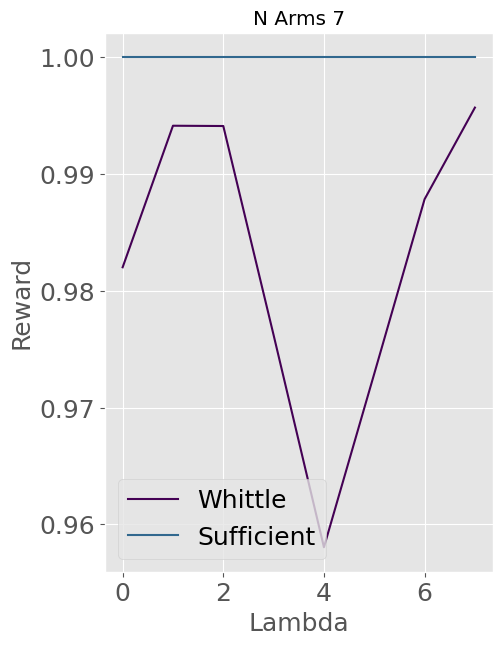

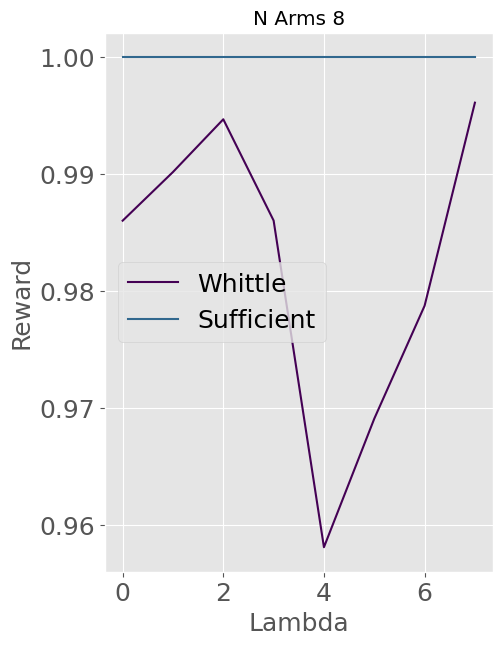

In [7]:
combined = get_results_matching_parameters("combined","results",{})
n_arms = [7,8]
data_by_arms = {}
for n in n_arms:

    keys = ['whittle_active','whittle_match',
    'sufficient_active','sufficient_match']
    data_by_arms[n] = {}

    for k in keys:
        data_by_arms[n][k] = []

    for data in combined:
        if data['parameters']['n_arms'] == n:
            for k in keys:
                data_by_arms[n][k].append(data[k])
            data_by_arms[n]['lambda_list'] = data['parameters']['lambda_list']
    
    for k in keys:
        data_by_arms[n][k] = np.mean(data_by_arms[n][k],axis=0)
    
color_palette = plt.cm.viridis(np.linspace(0, 1, 4))  # Change the colormap as needed

for n in n_arms:
    fig, ax = plt.subplots(figsize=(5,7))
    ax.set_title("N Arms {}".format(n))

    x_vals = [0,1,2,4,8,16,32,64] 
    x_vals = np.array([i/n for i in x_vals])


    for i,(k, name) in enumerate(zip(['whittle','sufficient'],
                    ['Whittle','Sufficient'])):
        y_vals = np.array(data_by_arms[n]['{}_active'.format(k)])*x_vals*n
        y_vals += np.array(data_by_arms[n]['{}_match'.format(k)])
        max_y_vals = np.array(data_by_arms[n]['{}_active'.format('sufficient')])*x_vals*n
        max_y_vals += np.array(data_by_arms[n]['{}_match'.format('sufficient')])
        y_vals /= max_y_vals 

        
        print("y_vals {} for {}".format(y_vals,name))

        real_x_vals = list(range(len(x_vals)))
        plt.plot(real_x_vals,y_vals,label=name,color=color_palette[i])

    plt.xlabel("Lambda")
    plt.ylabel("Reward")
    plt.legend() 

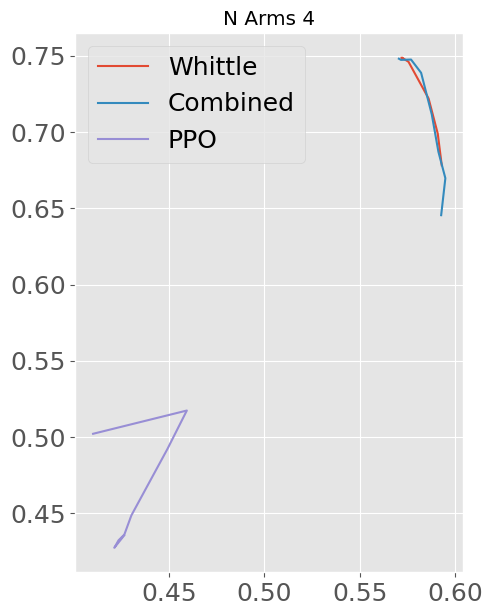

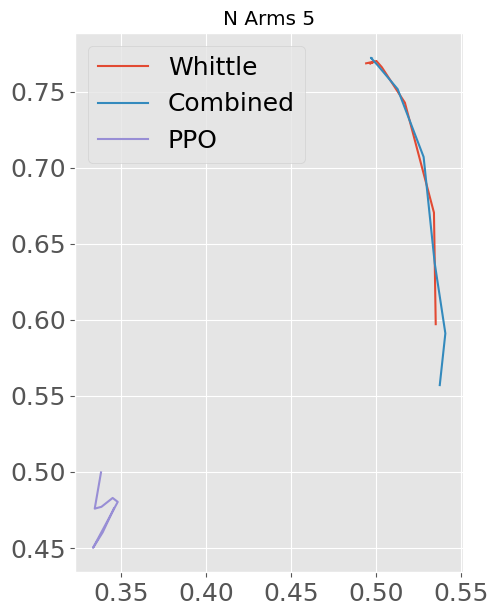

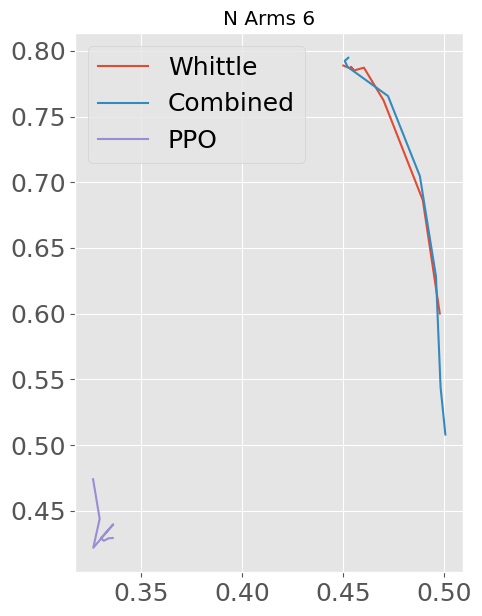

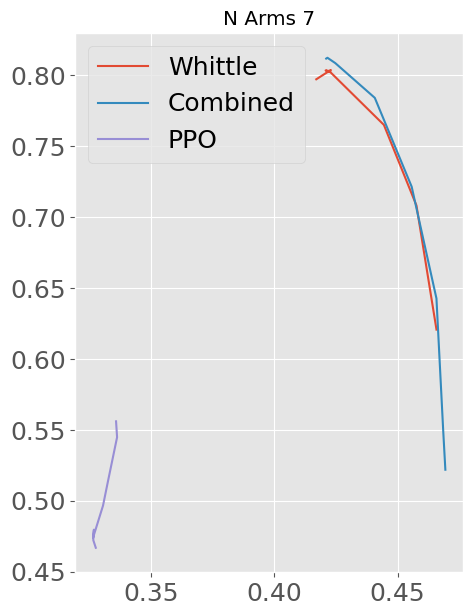

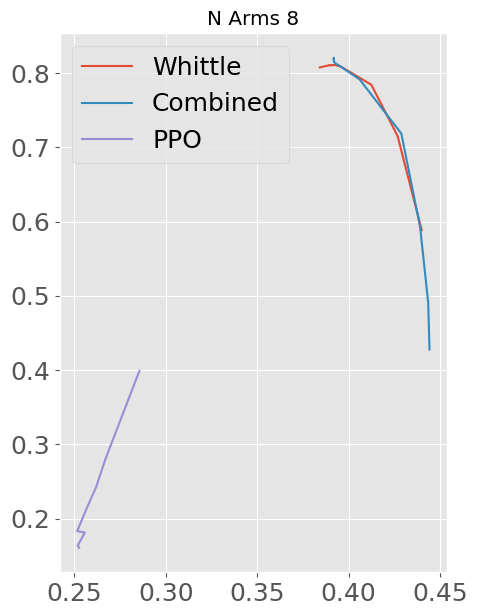

In [6]:
combined = get_results_matching_parameters("combined","results",{})
n_arms = [4,5,6,7,8]
data_by_arms = {}
for n in n_arms:
    keys = ['whittle_active','whittle_match',
    'sufficient_active','sufficient_match','neural_active','neural_match']
    data_by_arms[n] = {}

    for k in keys:
        data_by_arms[n][k] = []

    for data in combined:
        if data['parameters']['n_arms'] == n:
            for k in keys:
                data_by_arms[n][k].append(data[k])
    
    for k in keys:
        data_by_arms[n][k] = np.mean(data_by_arms[n][k],axis=0)

for n in n_arms:
    fig, ax = plt.subplots(figsize=(5,7))
    ax.set_title("N Arms {}".format(n))

    plt.plot(data_by_arms[n]['whittle_active'],data_by_arms[n]['whittle_match'],label='Whittle')
    plt.plot(data_by_arms[n]['sufficient_active'],data_by_arms[n]['sufficient_match'],label='Combined')
    plt.plot(data_by_arms[n]['neural_active'],data_by_arms[n]['neural_match'],label='PPO')
    plt.legend() 
    plt.show() 